Thanks to https://www.kaggle.com/xhlulu/ranzcr-efficientnet-tpu-training

In [1]:
!pip install efficientnet -q

In [2]:
import os

import efficientnet.tfkeras as efn
import numpy as np
import pandas as pd
from kaggle_datasets import KaggleDatasets
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.model_selection import GroupKFold

In [3]:
def auto_select_accelerator():
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        tf.config.experimental_connect_to_cluster(tpu)
        tf.tpu.experimental.initialize_tpu_system(tpu)
        strategy = tf.distribute.experimental.TPUStrategy(tpu)
        print("Running on TPU:", tpu.master())
    except ValueError:
        strategy = tf.distribute.get_strategy()
    print(f"Running on {strategy.num_replicas_in_sync} replicas")
    
    return strategy


def build_decoder(with_labels=True, target_size=(256, 256), ext='jpg'):
    def decode(path):
        file_bytes = tf.io.read_file(path)

        if ext == 'png':
            img = tf.image.decode_png(file_bytes, channels=3)
        elif ext in ['jpg', 'jpeg']:
            img = tf.image.decode_jpeg(file_bytes, channels=3)
        else:
            raise ValueError("Image extension not supported")
        img = tf.cast(img, tf.float32) / 255.0
        img = tf.image.resize(img, target_size)

        return img
    
    def decode_with_labels(path, label):
        return decode(path), label
    
    return decode_with_labels if with_labels else decode


def build_augmenter(with_labels=True):
    def augment(img):
        img = tf.image.random_flip_left_right(img)
        img = tf.image.random_flip_up_down(img)
        return img
    
    def augment_with_labels(img, label):
        return augment(img), label
    
    return augment_with_labels if with_labels else augment


def build_dataset(paths, labels=None, bsize=128, cache=True,
                  decode_fn=None, augment_fn=None,
                  augment=True, repeat=True, shuffle=1024, 
                  cache_dir=""):
    if cache_dir != "" and cache is True:
        os.makedirs(cache_dir, exist_ok=True)
    
    if decode_fn is None:
        decode_fn = build_decoder(labels is not None)
    
    if augment_fn is None:
        augment_fn = build_augmenter(labels is not None)
    
    AUTO = tf.data.experimental.AUTOTUNE
    slices = paths if labels is None else (paths, labels)
    
    dset = tf.data.Dataset.from_tensor_slices(slices)
    dset = dset.map(decode_fn, num_parallel_calls=AUTO)
    dset = dset.cache(cache_dir) if cache else dset
    dset = dset.map(augment_fn, num_parallel_calls=AUTO) if augment else dset
    dset = dset.repeat() if repeat else dset
    dset = dset.shuffle(shuffle) if shuffle else dset
    dset = dset.batch(bsize).prefetch(AUTO)
    
    return dset

In [4]:
COMPETITION_NAME = "siimcovid19-512-img-png-600-study-png"
strategy = auto_select_accelerator()
BATCH_SIZE = strategy.num_replicas_in_sync * 16
GCS_DS_PATH = KaggleDatasets().get_gcs_path(COMPETITION_NAME)

Running on TPU: grpc://10.0.0.2:8470
Running on 8 replicas


In [5]:
load_dir = f"/kaggle/input/{COMPETITION_NAME}/"
df = pd.read_csv('../input/siim-covid19-detection/train_study_level.csv')
label_cols = df.columns[1:5]


In [6]:
gkf  = GroupKFold(n_splits = 5)
df['fold'] = -1
for fold, (train_idx, val_idx) in enumerate(gkf.split(df, groups = df.id.tolist())):
    df.loc[val_idx, 'fold'] = fold

In [7]:
for i in range(1):
    
    valid_paths = GCS_DS_PATH + '/study/' + df[df['fold'] == i]['id'] + '.png' #"/train/"
    train_paths = GCS_DS_PATH + '/study/' + df[df['fold'] != i]['id'] + '.png' #"/train/" 
    valid_labels = df[df['fold'] == i][label_cols].values
    train_labels = df[df['fold'] != i][label_cols].values

    IMSIZE = (224, 240, 260, 300, 380, 456, 528, 600)
    IMS = 7

    decoder = build_decoder(with_labels=True, target_size=(IMSIZE[IMS], IMSIZE[IMS]), ext='png')
    test_decoder = build_decoder(with_labels=False, target_size=(IMSIZE[IMS], IMSIZE[IMS]),ext='png')

    train_dataset = build_dataset(
        train_paths, train_labels, bsize=BATCH_SIZE, decode_fn=decoder
    )

    valid_dataset = build_dataset(
        valid_paths, valid_labels, bsize=BATCH_SIZE, decode_fn=decoder,
        repeat=False, shuffle=False, augment=False
    )

    try:
        n_labels = train_labels.shape[1]
    except:
        n_labels = 1

    with strategy.scope():
        model = tf.keras.Sequential([
            efn.EfficientNetB7(
                input_shape=(IMSIZE[IMS], IMSIZE[IMS], 3),
                weights='imagenet',
                include_top=False),
            tf.keras.layers.GlobalAveragePooling2D(),
            tf.keras.layers.Dense(n_labels, activation='softmax')
        ])
        model.compile(
            optimizer=tf.keras.optimizers.Adam(),
            loss='categorical_crossentropy',
            metrics=['accuracy'])

        model.summary()


    steps_per_epoch = train_paths.shape[0] // BATCH_SIZE
    checkpoint = tf.keras.callbacks.ModelCheckpoint(
        f'model{i}.h5', save_best_only=True, monitor='val_loss', mode='min')
    lr_reducer = tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", patience=3, min_lr=1e-6, mode='min')

    history = model.fit(
        train_dataset, 
        epochs=20,
        verbose=1,
        callbacks=[checkpoint, lr_reducer],
        steps_per_epoch=steps_per_epoch,
        validation_data=valid_dataset)

    hist_df = pd.DataFrame(history.history)
    hist_df.to_csv(f'history{i}.csv')

258441216/258434480 [==============================] - 3s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b7 (Functional) (None, 19, 19, 2560)      64097680  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2560)              0         
_________________________________________________________________
dense (Dense)                (None, 4)                 10244     
Total params: 64,107,924
Trainable params: 63,797,204
Non-trainable params: 310,720
_________________________________________________________________
Epoch 1/20
37/37 [==============================] - 412s 5s/step - loss: 1.1661 - accuracy: 0.5422 - val_loss: 1.7177 - val_accuracy: 0.5161
Epoch 2/20
37/37 [==============================] - 57s 2s/step - loss: 1.0011 - accuracy: 0.6103 - val_loss: 1.2178 - val_accuracy: 0.6408
Epoch 3/20
37/37 [==

KeyboardInterrupt: 

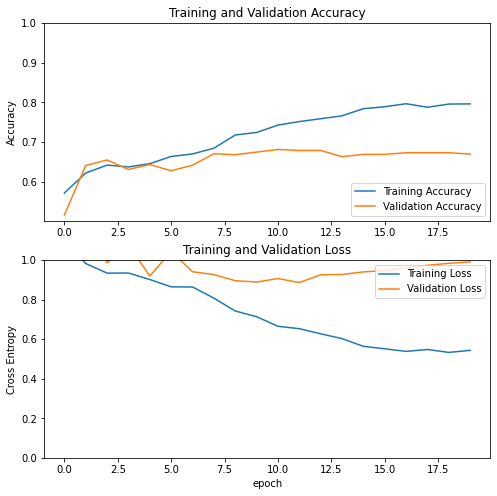

In [9]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()